In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pandas_datareader import data
from datetime import datetime
from numpy.linalg import inv
from scipy.stats import normaltest

from sklearn.linear_model import HuberRegressor
from sklearn.decomposition import PCA

from joblib import Parallel, delayed
import multiprocessing

import warnings
warnings.filterwarnings("ignore")

## Load observed covariates (FF3, FF5, FF5 + ETF9) and stock price data

In [2]:
ff3_raw = pd.read_csv('data/F-F_Research_Data_Factors_daily.csv',header = 1,skipfooter = 2)
ff3_raw.columns = ['Date','Mkt-RF', 'SMB', 'HML', 'RF']
ff3_raw.astype({'Date':'int'})
ff3_df = ff3_raw[(ff3_raw.Date >= 20050101) & (ff3_raw.Date <= 20131231)].drop('RF',axis=1)

In [3]:
ff5_raw = pd.read_csv('data/F-F_Research_Data_5_Factors_2x3_daily.csv',skipfooter = 2)
ff5_raw.columns = ['Date', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA', 'RF']
ff5_raw.astype({'Date':'int'})
ff5_df = ff5_raw[(ff5_raw.Date >= 20050101) & (ff5_raw.Date <= 20131231)].drop('RF',axis=1)

In [4]:
etf_list = ['XLE', 'XLB', 'XLI', 'XLY', 'XLP', 'XLV', 'XLF', 'XLK', 'XLU']
start_date = '2005-01-01'
end_date = '2013-12-31'

panel_data = data.DataReader('XLE', 'yahoo', start_date, end_date)
date = list(panel_data.index)

etf9_df = pd.DataFrame({'Date':date})
etf9_df['Date'] = etf9_df['Date'].apply(lambda x: int("".join(str(x).split()[0].split('-'))))
etf9_df.astype({'Date':'int'})
for stock in etf_list:
    try:
        to_add_stock = get_stock_value(stock)
        # only keep the stock with fully complete data
        if len(to_add_stock) == 2265:
                etf9_df[stock] = to_add_stock
    except:
        continue  

ff5_etf9_df = ff5_df.join(etf9_df.set_index('Date'),on='Date')

In [5]:
stock_df = pd.read_csv('data/stock_df.csv',index_col = 0)

In [6]:
ff3_df = ff3_df.drop(columns='Date')
ff5_df = ff5_df.drop(columns='Date')
ff5_etf9_df = ff5_etf9_df.drop(columns='Date')
stock_df = stock_df.drop(columns='Date')

exc_return = pd.DataFrame(stock_df.iloc[1:,:].values - stock_df.iloc[:2264,:].values,\
                          columns=stock_df.columns)
newrow = pd.DataFrame([[0]*363],columns=stock_df.columns)
exc_return_df = pd.concat([newrow,exc_return])

## Functions related with model construction and calculation

In [7]:
def augmented_factor(start,end,y,obs_factors):
    # y is a pd.DataFrame with samples at row and features at column
    # obs_facotors is a pd.DataFrame with samples at row and features at column
    def robust_fit(y):
        return(HuberRegressor(epsilon=1,max_iter=3000,alpha=0)\
               .fit(obs_factors.iloc[start:end,:], y).predict(obs_factors.iloc[start:end,:]))
    
    origin_y = y.iloc[start:end,:]
    pred_robust_df = origin_y.apply(robust_fit)
    pred_sigma = pred_robust_df.cov()

    K,N= obs_factors.shape[1] , origin_y.shape[1]
    T = origin_y.shape[0]
    
    pred_lambda= PCA(n_components=K,whiten=True).fit(pred_robust_df).components_*(N**0.5)
    pred_g = np.matmul(np.array(pred_robust_df),pred_lambda.transpose())/N
    pred_f = np.matmul(np.array(origin_y),pred_lambda.transpose())/N
    pred_gamma = pred_f - pred_g
    
    res_dict = {'lambda': pred_lambda, 'g':pred_g , 'f': pred_f, 'gamma': pred_gamma}
    return(res_dict)

In [8]:
def test_s_calculation(origin_y,res):
    T = origin_y.shape[0]
    N = origin_y.shape[1]
    pred_u = origin_y - np.matmul(res['f'],res['lambda'])
    pred_sigma_u = np.diag(pred_u.apply(lambda x: x**2).sum())/T
    pred_w = inv(np.matmul(np.matmul(res['lambda'],pred_sigma_u),res['lambda'].transpose())/N)
    pred_S = N/T*sum([pred_w.dot(res['gamma'][i]).dot(res['gamma'][i]) for i in range(0,res['gamma'].shape[0])])
    return(pred_S)
    

In [9]:
def vol(res,T):
    return(sum([res['gamma'][i].dot(res['gamma'][i]) \
                for i in range(0,len(res['gamma']))])/T/21)

In [10]:
def get_test_stat(y,x,window_size):   
    # y is a pd.DataFrame with samples at row and features at column
    # obs_facotors is a pd.DataFrame with samples at row and features at column
    out_s = list()
    N = x.shape[0]
    for i in range(0,N-window_size):
        try:
            start,end = i,i+window_size
            res = augmented_factor(start,end,y,x)
            origin_y = y.iloc[start:end,:]
            S = test_s_calculation(origin_y,res)
            out_s.append(S)
        except:
            out_s.append(out_s[-1])
    return(out_s)

## Do Parallel calculations

The first three plots shows the 

In [11]:
factor_list = [ff3_df,ff5_df,ff5_etf9_df]
window_list = [21,63,126]

num_cores = multiprocessing.cpu_count()
res_par = Parallel(n_jobs=num_cores)(delayed(get_test_stat)(exc_return_df,x,window) for x in factor_list for window in window_list)

In [33]:
data1,data2,data3 = pd.DataFrame(res_par[0:9:3]).transpose(),pd.DataFrame(res_par[1:9:3]).transpose(),pd.DataFrame(res_par[2:9:3]).transpose()

In [13]:
data1.to_csv('temp/stock_out_data1.csv')
data2.to_csv('temp/stock_out_data2.csv')
data3.to_csv('temp/stock_out_data3.csv')

In [52]:
data1 = pd.read_csv('stock_out_data1.csv',index_col = 0)
data2 = pd.read_csv('stock_out_data2.csv',index_col = 0)
data3 = pd.read_csv('stock_out_data3.csv',index_col = 0)

data1.index = np.linspace(2005,2014,2244)
data2.index = np.linspace(2005,2014,2202)
data3.index = np.linspace(2005,2014,2139)

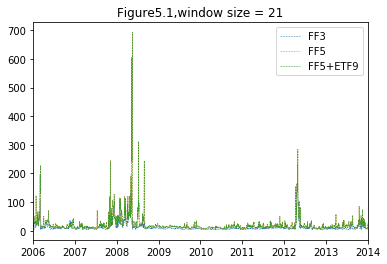

In [65]:
factor_name = ["FF3","FF5","FF5+ETF9"]

interval = list(range(252-21,len(data1)))

plt.plot(data1.iloc[interval,0],label = factor_name[0],linewidth = 0.5,linestyle='--')
plt.plot(data1.iloc[interval,1],label = factor_name[1],linewidth = 0.5,linestyle='--')
plt.plot(data1.iloc[interval,2],label = factor_name[2],linewidth = 0.5,linestyle='--')
plt.legend(loc = 'best')
plt.xlim(2006,2014)
plt.title('Figure5.1,window size = 21')
plt.savefig('pic/Figure5_1.png')
plt.show()

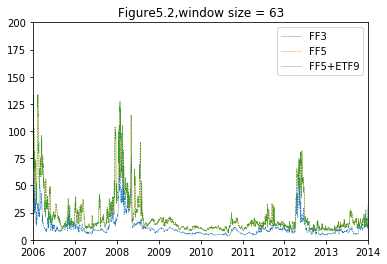

In [66]:
factor_name = ["FF3","FF5","FF5+ETF9"]

interval = list(range(252-63,len(data2)))

plt.plot(data2.iloc[interval,0],label = factor_name[0],linewidth = 0.5,linestyle='--')
plt.plot(data2.iloc[interval,1],label = factor_name[1],linewidth = 0.5,linestyle='--')
plt.plot(data2.iloc[interval,2],label = factor_name[2],linewidth = 0.5,linestyle='--')
plt.legend(loc = 'best')
plt.xlim(2006,2014)
plt.ylim(0,200)
plt.title('Figure5.2,window size = 63')
plt.savefig('pic/Figure5_2.png')
plt.show()

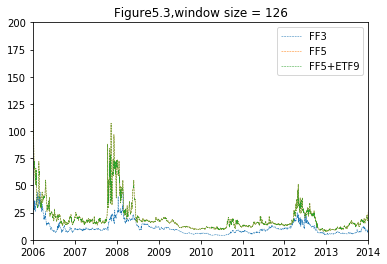

In [67]:
factor_name = ["FF3","FF5","FF5+ETF9"]

interval = list(range(252-21,len(data3)))

plt.plot(data3.iloc[interval,0],label = factor_name[0],linewidth = 0.5,linestyle='--')
plt.plot(data3.iloc[interval,1],label = factor_name[1],linewidth = 0.5,linestyle='--')
plt.plot(data3.iloc[interval,2],label = factor_name[2],linewidth = 0.5,linestyle='--')
plt.legend(loc = 'best')
plt.xlim(2006,2014)
plt.ylim(0,200)
plt.title('Figure5.3,window size = 126')
plt.savefig('pic/Figure5_3.png')
plt.show()